<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/tutorials/blob/master/image-classification/face-emotion.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/tutorials/blob/master/image-classification/face-emotion.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Face Emotion Classification



## 1. Setup

In [1]:
import os
import sys
!{sys.executable} -m pip install numpy matplotlib tensorflow gdown

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

print(f"System version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")

System version: 3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:24:51) [MSC v.1940 64 bit (AMD64)]
Tensorflow version: 2.18.0


## 2. Dataset

[Facial Expression Recognition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) data terdiri dari gambar wajah skala abu-abu berukuran 48x48 piksel. Tugasnya adalah mengkategorikan setiap wajah berdasarkan emosi yang ditunjukkan dalam ekspresi wajah ke dalam salah satu dari tujuh kategori (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

Dalam tutorial ini, kami mengadaptasi dataset asli untuk membentuk tugas klasifikasi biner yang mengkategorikan setiap wajah ke dalam salah satu dari dua kategori (0=Sad(Sedih), 1=Senang(Happy)).

In [2]:
# Mengimpor library gdown untuk mengunduh file dari Google Drive
import gdown

# Menyimpan ID unik dari file Google Drive
# ID ini bisa ditemukan di URL file Drive (contohnya di link berbentuk https://drive.google.com/file/d/<FILE_ID>/view)
file_id = "15UqVa22zQYnEYI3iKptZ7FksldbMmzyT"

# Menentukan nama file hasil download yang akan disimpan di komputer
# Dalam hal ini, file akan disimpan dengan nama "data.zip"
output = "data.zip"

# Mengunduh file dari Google Drive menggunakan gdown
# Parameter:
# - id=file_id → menentukan file mana yang akan diunduh berdasarkan ID-nya
# - output=output → menentukan nama file hasil unduhan
# - quiet=False → menampilkan progress bar selama proses download
gdown.download(id=file_id, output=output, quiet=False)



Downloading...
From (original): https://drive.google.com/uc?id=15UqVa22zQYnEYI3iKptZ7FksldbMmzyT
From (redirected): https://drive.google.com/uc?id=15UqVa22zQYnEYI3iKptZ7FksldbMmzyT&confirm=t&uuid=b51b4678-d41e-479d-b6ed-d3122bcc0d09
To: C:\Bonz\data_science\AKMIL\data.zip
100%|█████████████████████████████████████████████████████████████████████████████| 10.3M/10.3M [00:03<00:00, 2.99MB/s]


'data.zip'

In [3]:
# Mengimpor modul 'zipfile' untuk bekerja dengan file ZIP (membuka, mengekstrak, dll)
import zipfile

# Mengimpor modul 'os' untuk mengakses fungsi sistem operasi (misalnya mencari path absolut)
import os

# Menentukan lokasi file ZIP yang akan diekstrak
zip_path = "data.zip"

# Menentukan folder tujuan hasil ekstraksi
# Tanda "." berarti folder saat ini (root folder tempat notebook dijalankan)
extract_to = "."

# Membuka file ZIP dalam mode 'read' (r)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Mengekstrak semua isi file ZIP ke folder tujuan
    zip_ref.extractall(extract_to)

# Menampilkan pesan konfirmasi lokasi hasil ekstraksi
# os.path.abspath() digunakan untuk menampilkan path lengkap (absolute path) dari folder tujuan
print(f"Unzipped to: {os.path.abspath(extract_to)}")


Unzipped to: C:\Bonz\data_science\AKMIL


In [5]:
# Mengimpor modul os untuk bekerja dengan sistem file dan direktori
import os

# Menentukan path ke folder yang berisi gambar-gambar
# Dalam hal ini, gambar-gambar disimpan di dalam folder 'data/images'
image_dir = "data/images"

# Mengambil daftar semua file yang ada di dalam folder 'image_dir'
# os.listdir() akan mengembalikan list nama file dan folder di dalam direktori tersebut
files = os.listdir(image_dir)

# Menampilkan jumlah total file yang ditemukan di dalam folder 'data/images'
print(f"Found {len(files)} files:")

# Menampilkan 10 file pertama dari daftar file (untuk pengecekan cepat)
print(files[:10])


Found 2 files:
['0', '1']


### Siapkan data

Mari kita gunakan 90% data untuk pelatihan model dan 10% untuk validasi model.

In [6]:
# Menentukan parameter konfigurasi dataset
val_size = 0.1        # Rasio data yang digunakan untuk validasi (10% dari seluruh data)
batch_size = 32       # Jumlah sampel per batch saat training
img_height = 48       # Tinggi gambar setelah di-resize
img_width = 48        # Lebar gambar setelah di-resize

# Membuat dataset untuk training dari folder 'data/images'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "data/images",                       # Direktori utama yang berisi gambar yang dikelompokkan per folder label
  validation_split=val_size,           # Split data menjadi data training dan validasi
  subset="training",                   # Menentukan ini adalah bagian training dari data
  seed=123,                            # Seed acak agar pemisahan data konsisten setiap kali dijalankan
  color_mode='grayscale',              # Mengatur agar gambar dibaca dalam skala abu-abu (1 channel)
  image_size=(img_height, img_width),  # Resize gambar ke ukuran 48x48
  batch_size=batch_size)               # Membagi data menjadi batch-batch berukuran 32

# Membuat dataset untuk validasi dari folder yang sama dengan konfigurasi identik
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "data/images",                       # Direktori yang sama dengan data training
  validation_split=val_size,           # Split yang sama: 10% untuk validasi
  subset="validation",                 # Bagian ini digunakan untuk validasi
  seed=123,                            # Seed yang sama untuk konsistensi
  color_mode='grayscale',              # Mengatur agar gambar dibaca dalam skala abu-abu (1 channel)
  image_size=(img_height, img_width),  # Resize gambar ke ukuran 48x48
  batch_size=batch_size)               # Batch size sama dengan training

# Mengatur agar pemuatan data dilakukan secara efisien saat training
AUTOTUNE = tf.data.AUTOTUNE            # TensorFlow akan otomatis menentukan buffer size terbaik

# Cache data agar tidak perlu membaca ulang dari disk setiap epoch
# Prefetch digunakan agar data berikutnya siap sebelum digunakan, mempercepat proses training
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 9660 files belonging to 2 classes.
Using 8694 files for training.
Found 9660 files belonging to 2 classes.
Using 966 files for validation.


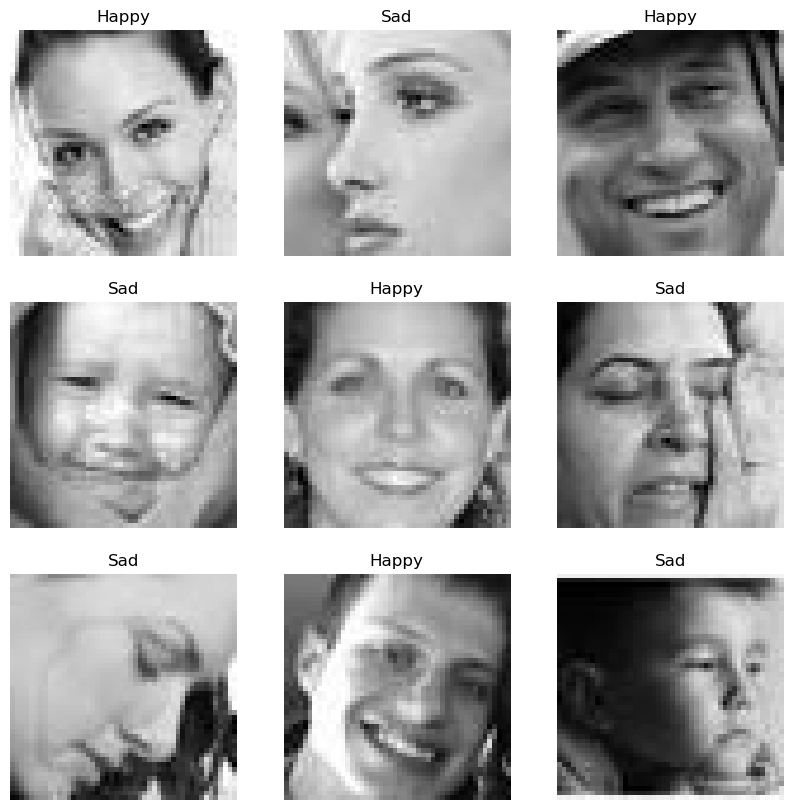

In [7]:
# Mendefinisikan label nama kelas secara manual
# Pastikan urutan label sesuai dengan urutan folder di data/images
class_names = ['Sad', 'Happy']

# Membuat canvas figure ukuran 10x10 inci untuk menampilkan gambar-gambar
plt.figure(figsize=(10, 10))

# Mengambil satu batch data dari train_ds (batch pertama)
# train_ds.take(1) akan mengembalikan satu batch berupa (images, labels)
for images, labels in train_ds.take(1):
  for i in range(9):                                                           # Menampilkan 9 gambar pertama dari batch tersebut
    ax = plt.subplot(3, 3, i + 1)                                              # Membuat subplot 3x3 di posisi ke-i+1
    plt.imshow(images[i].numpy().astype("uint8").reshape(48, 48), cmap='gray') # Menampilkan gambar ke-i dalam format numpy array
    plt.title(class_names[labels[i]])                                          # Menampilkan judul gambar sesuai dengan nama kelasnya
    plt.axis("off")                                                            # Menyembunyikan sumbu (axis) agar tampilan lebih bersih

## 3. Multilayer Perceptron (MLP)


In [8]:
# Hyperparameter untuk model
hidden_units = 128     # Jumlah neuron pada layer Dense
dropout_rate = 0.2     # Rasio dropout untuk regularisasi (mengurangi overfitting)
learning_rate = 0.01   # Learning rate untuk optimizer

# Membangun model MLP (Multi-Layer Perceptron) dengan TensorFlow Keras
mlp_model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_height, img_width, 1)),       # Input shape sesuai ukuran gambar (48x48) dan 1 channel (grayscale)
  tf.keras.layers.RandomFlip('horizontal'),               # Augmentasi: Membalik gambar secara horizontal secara acak saat training
  tf.keras.layers.Rescaling(1./127.5, offset=-1),         # Rescaling nilai piksel dari [0, 255] ke [-1, 1] untuk normalisasi                       
  tf.keras.layers.Flatten(),                              # Mengubah input 2D (gambar) menjadi vektor 1D
  tf.keras.layers.Dense(hidden_units, activation='relu'), # Layer Dense pertama dengan aktivasi ReLU
  tf.keras.layers.Dropout(rate=dropout_rate),             # Dropout untuk mencegah overfitting
  tf.keras.layers.Dense(hidden_units, activation='relu'), # Layer Dense kedua dengan jumlah neuron yang sama
  tf.keras.layers.Dense(2)                                # Layer output: 2 unit (karena 2 kelas), tanpa aktivasi karena pakai from_logits=True
], name="MLP")

# Menyusun (compile) model
mlp_model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate, momentum=0.9),  # Optimizer SGD dengan momentum
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),  # Loss untuk klasifikasi dengan label numerik (bukan one-hot)
  metrics=['accuracy']                                             # Metrik evaluasi: akurasi
)

# Menampilkan ringkasan arsitektur model
mlp_model.summary() 

Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 311,810 (1.19 MB)

 Trainable params: 311,810 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Melatih model MLP menggunakan dataset training dan validasi
mlp_model.fit(
  train_ds,                 # Dataset training
  validation_data=val_ds,   # Dataset validasi untuk mengevaluasi performa tiap epoch
  epochs=20                 # Jumlah epoch (berapa kali seluruh data dilatih)
);


Epoch 1/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - accuracy: 0.6033 - loss: 0.6704 - val_accuracy: 0.7081 - val_loss: 0.5917
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6908 - loss: 0.5898 - val_accuracy: 0.7174 - val_loss: 0.5658
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7137 - loss: 0.5666 - val_accuracy: 0.7381 - val_loss: 0.5351
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7362 - loss: 0.5399 - val_accuracy: 0.7288 - val_loss: 0.5245
Epoch 5/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7387 - loss: 0.5222 - val_accuracy: 0.7319 - val_loss: 0.5223
Epoch 6/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7514 - loss: 0.5070 - val_accuracy: 0.7660 - val_loss: 0.5028
Epoch 7/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7536 - loss: 0.4997 - val_accuracy: 0.7598 - val_loss: 0.5005
Epoch 8/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7651 - loss: 0.4888 - val_accuracy: 

## 4. Shallow CNN



In [10]:
# Hyperparameter untuk CNN
filters = 32               # Jumlah filter pada layer Conv2D
kernel_size = [3, 3]       # Ukuran kernel/filter 3x3
strides = 1                # Langkah pergerakan filter
hidden_units = 128         # Jumlah neuron di layer Dense
dropout_rate = 0.2         # Rasio dropout untuk regularisasi
learning_rate = 0.01       # Learning rate untuk optimizer

# Membangun model Shallow CNN (Convolutional Neural Network) menggunakan Sequential API
shallow_cnn_model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_height, img_width, 1)),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.Rescaling(1./127.5, offset=-1),  
  tf.keras.layers.Conv2D(filters, kernel_size, strides, padding='same', activation='relu'), # Layer konvolusi: mendeteksi fitur lokal dari gambar
  tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2),                                # Max pooling: mengurangi dimensi dan menangkap fitur penting
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(rate=dropout_rate),
  tf.keras.layers.Dense(hidden_units, activation='relu'),
  tf.keras.layers.Dense(2)
], name="Shallow-CNN")

# Menyusun (compile) model
shallow_cnn_model.compile(                  
  optimizer=tf.keras.optimizers.SGD(learning_rate, momentum=0.9), # Optimizer SGD dengan momentum
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), # Loss untuk klasifikasi dengan label numerik (bukan one-hot)
  metrics=['accuracy']                                            # Metrik evaluasi: akurasi
)

# Menampilkan arsitektur model CNN
shallow_cnn_model.summary()

Model: "Shallow-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,360,002 (9.00 MB)

 Trainable params: 2,360,002 (9.00 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Melatih model Shallow CNN menggunakan dataset training dan validasi
shallow_cnn_model.fit(
  train_ds,                 # Dataset training
  validation_data=val_ds,   # Dataset validasi untuk mengevaluasi performa tiap epoch
  epochs=20                 # Jumlah epoch (berapa kali seluruh data dilatih)
);


Epoch 1/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6200 - loss: 0.6410 - val_accuracy: 0.7484 - val_loss: 0.5420
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7264 - loss: 0.5378 - val_accuracy: 0.7433 - val_loss: 0.5149
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7512 - loss: 0.4977 - val_accuracy: 0.7640 - val_loss: 0.4969
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7760 - loss: 0.4584 - val_accuracy: 0.7692 - val_loss: 0.4734
Epoch 5/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7916 - loss: 0.4351 - val_accuracy: 0.7826 - val_loss: 0.4679
Epoch 6/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.8100 - loss: 0.4073 - val_accuracy: 0.7816 - val_loss: 0.4756
Epoch 7/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.8223 - loss: 0.3813 - val_accuracy: 0.7826 - val_loss: 0.4734
Epoch 8/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.8446 - loss: 0.3429 - val_acc

## 5. Deep CNN

In [13]:
# Hyperparameter untuk CNN
filters = 32               # Jumlah filter pada layer Conv2D
kernel_size = [3, 3]       # Ukuran kernel/filter 3x3
strides = 1                # Langkah pergerakan filter
hidden_units = 128         # Jumlah neuron di layer Dense
dropout_rate = 0.2         # Rasio dropout untuk regularisasi
learning_rate = 0.01       # Learning rate untuk optimizer

# Membangun model Deep CNN (Convolutional Neural Network) menggunakan Sequential API
deep_cnn_model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_height, img_width, 1)),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.Rescaling(1./127.5, offset=-1),
  layers.Conv2D(filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Conv2D(2 * filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Conv2D(4 * filters, kernel_size, strides, padding='same', activation='relu'),
  layers.Conv2D(4 * filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Flatten(),
  layers.Dropout(rate=dropout_rate),
  layers.Dense(hidden_units, activation='relu'),
  layers.Dense(2)
], name="Deep-CNN")

deep_cnn_model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate,  momentum=0.9),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

deep_cnn_model.summary()

Model: "Deep-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 830,466 (3.17 MB)

 Trainable params: 830,466 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = deep_cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - accuracy: 0.5831 - loss: 0.6691 - val_accuracy: 0.6843 - val_loss: 0.5851
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - accuracy: 0.7215 - loss: 0.5524 - val_accuracy: 0.7598 - val_loss: 0.5050
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.7701 - loss: 0.4648 - val_accuracy: 0.7909 - val_loss: 0.4401
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.8037 - loss: 0.4116 - val_accuracy: 0.8251 - val_loss: 0.3772
Epoch 5/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.8341 - loss: 0.3625 - val_accuracy: 0.8561 - val_loss: 0.3340
Epoch 6/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.8551 - loss: 0.3237 - val_accuracy: 0.8509 - val_loss: 0.3346
Epoch 7/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.8668 - loss: 0.3027 - val_accuracy: 0.8520 - val_loss: 0.3170
Epoch 8/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.8781 - loss: 0.2871 

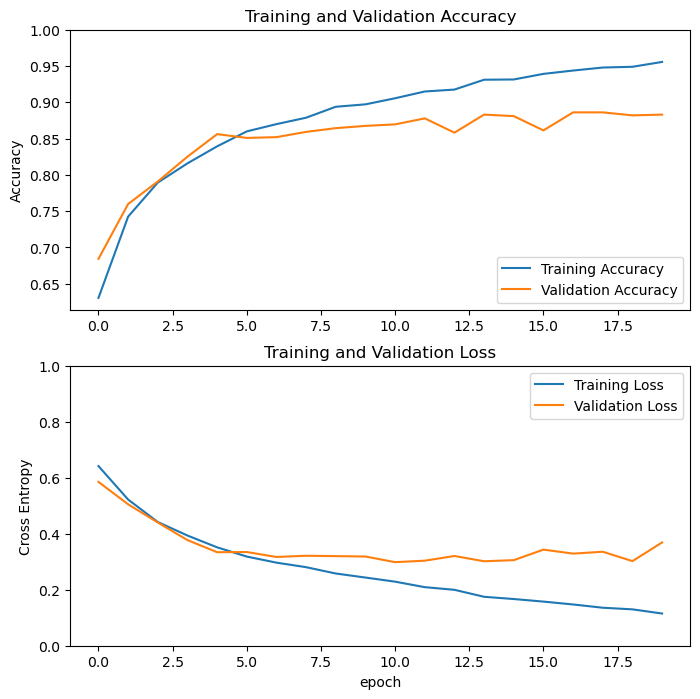

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 6. Visualization of Learned CNN Filters

Here we visualize the Deep CNN model with saliency map of images using [Guided Backpropagation](https://arxiv.org/abs/1412.6806) technique, and the activation maps of the 4th convolutional layer of the network.

We may notice that the model focuses more on the mouth with Happy emotion, while other parts of the face are paid attention with Sad emotion.

| Input Image                                                                                                                      | Saliency Map                                                                                                                                  | Activation Maps of the 4th Convolutional Layer                                                                                       | Label |
| :------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :------------------------------------------------------------------------------------------------------------------------------------: | :---: |
| ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/82.jpg)  | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/saliency_map_82.jpg)  | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/conv4_82.jpg)  | Happy |
| ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/130.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/saliency_map_130.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/conv4_130.jpg) | Sad   |
| ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/791.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/saliency_map_791.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/conv4_791.jpg) | Happy |
| ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/607.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/saliency_map_607.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/conv4_607.jpg) | Sad   |

Please refer to this [code](https://github.com/PreferredAI/tutorials/blob/7ccc67cde2408c873a6cba66b58ec56dee236a17/image-classification/face-emotion/src/visualize.py) for more details.